In [99]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
folder_path = 'mouseDataExpBCompl'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
# filenames = [os.path.basename(file) for file in csv_files]

In [100]:
exclusion_df = pd.read_csv('df_for_trialexclusion.csv') 
# habe in trialexecution block zu round umbenannt
excluded = exclusion_df[exclusion_df['trial_excl'] == 1][['id', 'round', 'trial']]
dataframes_without_excluded = []

for df in dataframes:
    if all(col in df.columns for col in ['id', 'round', 'trial']):
        merged = df.merge(excluded, on=['id', 'round', 'trial'], how='left', indicator=True)
        df_cleaned = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
        dataframes_without_excluded.append(df_cleaned)
    else:
        dataframes_without_excluded.append(df) 

In [101]:
print(len(dataframes_without_excluded[0]))
print(len(dataframes[0]))

88112
96422


In [102]:
cleaned_dataframes = []

for df in dataframes_without_excluded:
    df_cleaned = df[df['phase'] != 'waitingForTarget']                         # Phase-Filter
    df_cleaned = df_cleaned[(df_cleaned['round'] >= 1) & (df_cleaned['round'] <= 8)]  # Runden 1–8 behalten
    df_cleaned = df_cleaned.reset_index(drop=True)
    cleaned_dataframes.append(df_cleaned)


In [103]:
len(cleaned_dataframes[0])

31993

In [104]:
cleaned_dataframes[0]

,id,round,trial,version,timestamp,frame,relative_time,mouse_x,mouse_y,mouse_dx,mouse_dy,phase,event
0,1085,1,2,lld,14:14:18.273,8389,0.017,0.101,0.023,0.0,0.0,activeTracking,targetAppeared
1,1085,1,2,lld,14:14:18.289,8390,0.034,0.101,0.023,0.0,0.0,activeTracking,noEvent
2,1085,1,2,lld,14:14:18.307,8391,0.051,0.101,0.023,0.0,0.0,activeTracking,noEvent
3,1085,1,2,lld,14:14:18.323,8392,0.068,0.101,0.023,0.0,0.0,activeTracking,noEvent
4,1085,1,2,lld,14:14:18.340,8393,0.084,0.101,0.023,0.0,0.0,activeTracking,noEvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31988,1085,8,60,lld,14:44:01.441,115133,1.148,-2.610,0.037,0.0,0.0,onTarget,noEvent
31989,1085,8,60,lld,14:44:01.459,115134,1.165,-2.610,0.037,0.0,0.0,onTarget,noEvent
31990,1085,8,60,lld,14:44:01.477,115135,1.183,-2.610,0.037,0.0,0.0,onTarget,noEvent
31991,1085,8,60,lld,14:44:01.495,115136,1.202,-2.610,0.037,0.0,0.0,onTarget,noEvent


### Blöcke nach round und trial gruppieren (eine zeile enthält einen trial)

In [105]:
all_grouped_df = []
for dataframe in cleaned_dataframes:
    df_grouped = dataframe.groupby(['round', 'trial']).agg({
        'timestamp': list,
        'mouse_x': list,
        'mouse_y': list,
        'version': 'first',  # Falls du version behalten willst
        'id': 'first'
    }).reset_index()

    all_grouped_df.append(df_grouped)

In [106]:
len(all_grouped_df[0])

439

### Normalisieren auf 0/0

In [107]:
def normalize_positions(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    
    x_start, y_start = x_positions[0], y_positions[0]
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    row["mouse_x"] = x_norm
    row["mouse_y"] = y_norm

    return row


In [108]:
processed_dataframes = []
for df in all_grouped_df:
    df_processed = df.apply(normalize_positions, axis=1)
    processed_dataframes.append(df_processed)

In [109]:
processed_dataframes[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id
0,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085
3,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085
4,1,6,"[14:14:33.072, 14:14:33.089, 14:14:33.106, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0219999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085
...,...,...,...,...,...,...,...
434,8,56,"[14:43:43.159, 14:43:43.175, 14:43:43.191, 14:...","[0.0, 0.01100000000000001, 0.03800000000000000...","[0.0, 0.0, 0.0, 0.0, -0.01100000000000001, -0....",lld,1085
435,8,57,"[14:43:48.209, 14:43:48.225, 14:43:48.245, 14:...","[0.0, -0.10999999999999999, -0.192, -0.2870000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085
436,8,58,"[14:43:51.614, 14:43:51.624, 14:43:51.641, 14:...","[0.0, -0.0030000000000000027, -0.0270000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000000...",lld,1085
437,8,59,"[14:43:55.442, 14:43:55.460, 14:43:55.475, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.000999999999999994, 0.0009999999999999...",lld,1085


### Euklidische distanz ausrechnen und als spalte hinzufügen: 

In [110]:
def calculate_euclidean_distances(row):
    x = row['mouse_x']
    y = row['mouse_y']
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    return np.insert(dist, 0, 0.0)  # Schrittweiten, erste ist 0


In [111]:
processed_dataframes[49] # da sind machneche mouse_x keine arrays, sondern einfach nur 0.0

,round,trial,timestamp,mouse_x,mouse_y,version,id
0,1,2,"[15:04:10.698, 15:04:10.705, 15:04:10.712, 15:...","[0.0, 0.0010000000000000009, 0.001000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,9630
1,1,3,"[15:04:13.528, 15:04:13.535, 15:04:13.542, 15:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -0.015000000000000001, -0.01999999999999...",rld,9630
2,1,4,"[15:04:16.809, 15:04:16.816, 15:04:16.823, 15:...","[0.0, -0.0010000000000000009, -0.0010000000000...","[0.0, -0.0010000000000000009, -0.0010000000000...",rld,9630
3,1,5,"[15:04:19.374, 15:04:19.381, 15:04:19.388, 15:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,9630
4,1,6,"[15:04:22.078, 15:04:22.085, 15:04:22.092, 15:...","[0.0, -0.018000000000000016, -0.03500000000000...","[0.0, 0.000999999999999994, 0.0129999999999999...",rld,9630
...,...,...,...,...,...,...,...
465,8,55,"[15:26:37.020, 15:26:37.027, 15:26:37.034, 15:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.01200000000000001,...","[0.0, 0.0, 0.012000000000000004, 0.016, 0.017,...",rld,9630
466,8,56,"[15:26:38.473, 15:26:38.480, 15:26:38.487, 15:...","[0.0, -0.028999999999999915, -0.03899999999999...","[0.0, 0.0019999999999999983, 0.002999999999999...",rld,9630
467,8,57,"[15:26:40.037, 15:26:40.044, 15:26:40.051, 15:...","[0.0, -0.006000000000000227, -0.02000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000000...",rld,9630
468,8,58,"[15:26:41.414, 15:26:41.421, 15:26:41.427, 15:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01200000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.01200000000000001,...",rld,9630


In [112]:
# die mal rausschmeißen
def is_valid_array(val):
    import numpy as np
    if not isinstance(val, np.ndarray):
        return False
    try:
        return len(val) > 1
    except TypeError:
        return False

# Liste aus gefilterten DataFrames erzeugen
processed_dataframes_clean = []

for df in processed_dataframes:
    df_clean = df[df.apply(lambda row: is_valid_array(row['mouse_x']) and is_valid_array(row['mouse_y']), axis=1)]
    processed_dataframes_clean.append(df_clean)



In [113]:
for i, df in enumerate(processed_dataframes_clean):
    if df.empty:
        print(f"DataFrame {i} ist leer.")


DataFrame 7 ist leer.
DataFrame 30 ist leer.
DataFrame 48 ist leer.
DataFrame 52 ist leer.


In [114]:
processed_dataframes_clean = [
    df for df in processed_dataframes_clean
    if isinstance(df, pd.DataFrame) and not df.empty
]

In [115]:

for df in processed_dataframes_clean: 
    df['euk_dist'] = df.apply(calculate_euclidean_distances, axis=1)

In [116]:
print(processed_dataframes_clean[0]["mouse_x"][0])
print(processed_dataframes_clean[0]["mouse_y"][0])
print(processed_dataframes_clean[0]["euk_dist"][0])

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.135 0.439 0.779 1.155 1.407 1.701 1.952 2.261
 2.667 3.114 3.495 3.779 3.981 4.049 4.072 4.08  4.082 4.083 4.083 4.083
 4.083 4.083 4.07  4.039 3.989 3.945 3.905 3.839 3.712 3.503 3.357 3.271
 3.192 3.154 3.116 3.078 3.066 3.049 3.031 3.025 3.023 2.985 2.973 2.944
 2.897 2.869 2.847 2.816 2.781 2.769 2.765 2.764 2.763 2.763 2.763 2.763
 2.763 2.763 2.763 2.763 2.763 2.763 2.763]
[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -0.09  -0.188 -0.243 -0.297
 -0.315 -0.322 -0.325 -0.327 -0.27  -0.146 -0.08  -0.008  0.053  0.074
  0.081  0.083  0.084  0.084  0.084  0.084  0.084  0.084  0.084  0.084
  0.096  0.112  0.117  0.142  0.15   0.15   0.15   0.15   0.149  0.149
  0.148  0.148  0.148  0.16   0.175  0.181  0.182  0.183  0.183  0.182
  0.182  0.17   0.142  0.121  0.114  0.112  0.111  0.111  0.111  0.11
  0.11   0.11   0.11   0.11 

In [117]:
processed_dataframes_clean[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist
0,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000..."
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0..."
3,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000..."
4,1,6,"[14:14:33.072, 14:14:33.089, 14:14:33.106, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0219999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02199999..."
...,...,...,...,...,...,...,...,...
434,8,56,"[14:43:43.159, 14:43:43.175, 14:43:43.191, 14:...","[0.0, 0.01100000000000001, 0.03800000000000000...","[0.0, 0.0, 0.0, 0.0, -0.01100000000000001, -0....",lld,1085,"[0.0, 0.01100000000000001, 0.02699999999999999..."
435,8,57,"[14:43:48.209, 14:43:48.225, 14:43:48.245, 14:...","[0.0, -0.10999999999999999, -0.192, -0.2870000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.10999999999999999, 0.08200000000000002..."
436,8,58,"[14:43:51.614, 14:43:51.624, 14:43:51.641, 14:...","[0.0, -0.0030000000000000027, -0.0270000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000000...",lld,1085,"[0.0, 0.0030000000000000027, 0.024000000000000..."
437,8,59,"[14:43:55.442, 14:43:55.460, 14:43:55.475, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.000999999999999994, 0.0009999999999999...",lld,1085,"[0.0, 0.000999999999999994, 0.0, 0.0, 0.0, 0.0..."


In [118]:
import pandas as pd
import numpy as np
from datetime import datetime

def calculate_speed(row, window_ms=5):
    timestamps = row['timestamp']  # Liste von Strings, z.B. ['14:14:14.373', '14:14:14.390', ...]
    euk_dist = row['euk_dist']     # Array von Distanzen zwischen aufeinanderfolgenden Messpunkten

    # 1. Timestamps in datetime-Objekte umwandeln (nur Zeit, ohne Datum)
    times = [datetime.strptime(ts, '%H:%M:%S.%f') for ts in timestamps]

    # 2. Zeitdifferenzen in Millisekunden zum Startzeitpunkt berechnen
    start_time = times[0]
    elapsed_ms = np.array([(t - start_time).total_seconds() * 1000 for t in times])

    # 3. Fenster-IDs zuweisen (jeder Zeitstempel kommt in ein Fenster von 0-5ms, 5-10ms, ...)
    window_ids = (elapsed_ms // window_ms).astype(int)

    # 4. Für jedes Fenster die Summe der euklidischen Distanzen berechnen
    # Achtung: euk_dist hat vermutlich eine Länge = len(timestamps), evtl. Off-by-One, 
    # falls euk_dist Distanzen zwischen Messpunkten sind, dann hat euk_dist = len(timestamps) - 1
    # Darum passen wir window_ids an:
    if len(euk_dist) == len(timestamps):
        dist_to_sum = np.array(euk_dist)
    elif len(euk_dist) == len(timestamps) - 1:
        dist_to_sum = np.array(euk_dist)
        window_ids = window_ids[:-1]  # letztes Zeitfenster fällt raus, weil keine Distanz danach
    else:
        raise ValueError("Längen von timestamps und euk_dist passen nicht zusammen")

    # Summe pro Fenster
    import collections
    dist_per_window = collections.defaultdict(float)
    for w_id, dist in zip(window_ids, dist_to_sum):
        dist_per_window[w_id] += dist

    # 5. Geschwindigkeit pro Fenster = Distanz / Zeit (Zeit = window_ms ms = window_ms / 1000 s)
    speed_per_window = {w: dist / (window_ms / 1000) for w, dist in dist_per_window.items()}

    # 6. Optional: Ergebnis als Liste zurückgeben, sortiert nach Fenster-ID
    max_window = max(window_ids)
    speeds = [speed_per_window.get(i, 0) for i in range(max_window + 1)]

    return speeds


In [119]:
for df in processed_dataframes_clean: 
    df['speed'] = df.apply(calculate_speed, axis=1)

In [120]:
processed_dataframes_clean[0]["speed"][0]

[np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 np.float64(0.0),
 0,
 0,
 0,
 np.float64(32.4499614791759),
 0,
 0,
 np.float64(63.88113962665351),
 0,
 0,
 0,
 np.float64(68.88396039717809),
 0,
 0,
 np.float64(75.97157363119446),
 0,
 0,
 np.float64(50.52840785142553),
 0,
 0,
 0,
 np.float64(58.81666430528002),
 0,
 0,
 np.float64(50.20358552932248),
 0,
 0,
 np.float64(61.80129448482454),
 0,
 0,
 0,
 np.float64(81.99634138179576),
 0,
 0,
 np.float64(92.77607450199649),
 0,
 0,
 np.float64(77.3348563068427),
 0,
 0,
 0,
 np.float64(58.596928247135914),
 0,
 0,
 np.float64(42.20189569201838),
 0,
 0,
 np.float64(14.23376267892656

In [121]:
import numpy as np

def interpolate_to_100(speed_list, target_length=100):
    if len(speed_list) == 0:
        return np.zeros(target_length)  # Falls leere Liste, dann nur Nullen

    # Originale x-Werte (Zeitpunkte) der Geschwindigkeiten: 0, 1, 2, ..., len(speed_list)-1
    original_x = np.linspace(0, 1, num=len(speed_list))
    # Neue x-Werte für genau 100 Punkte von 0 bis 1
    target_x = np.linspace(0, 1, num=target_length)

    # Interpolation
    interpolated = np.interp(target_x, original_x, speed_list)
    return interpolated


In [122]:
for df in processed_dataframes_clean: 
    df['speed_interp'] = df['speed'].apply(interpolate_to_100)


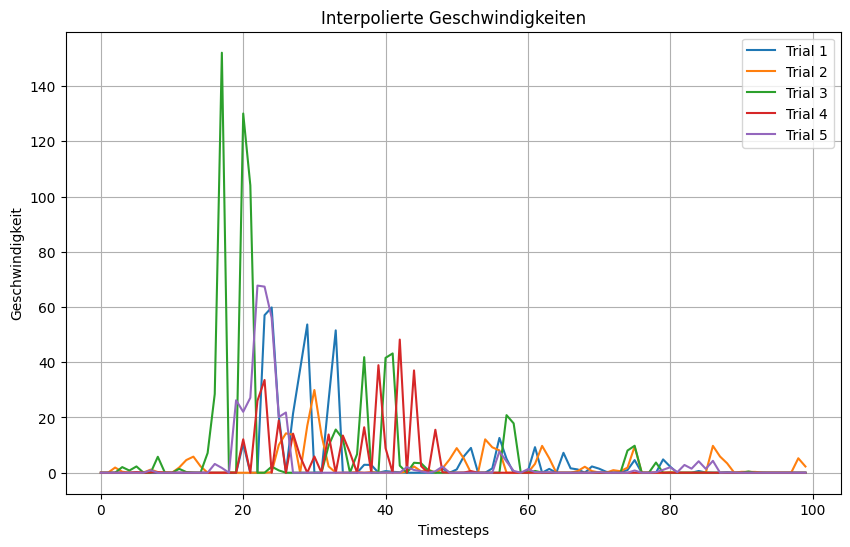

In [123]:
plt.figure(figsize=(10,6))
for i in range(min(5, len(processed_dataframes_clean[0]))):  # z.B. max 5 Trials
    speed_interp = processed_dataframes_clean[0]['speed_interp'].iloc[i]
    plt.plot(np.arange(100), speed_interp, label=f'Trial {i+1}')
plt.xlabel("Timesteps")
plt.ylabel("Geschwindigkeit")
plt.title("Interpolierte Geschwindigkeiten")
plt.legend()
plt.grid(True)
plt.show()


In [124]:
processed_dataframes_clean[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,speed_interp
0,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.0, 0, 0, 0.0, 0, 0, 3.2557641192199385, 0, ...","[0.0, 0.0, 1.8745308565205723, 0.3636363636363..."
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[0.0, 0, 0, 4.6, 0, 0, 1.6, 0, 0, 0, 0.4000000...","[0.0, 0.0, 0.0, 2.0363636363636393, 0.79191919..."
3,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 2.1999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.222222222222217, 0..."
4,1,6,"[14:14:33.072, 14:14:33.089, 14:14:33.106, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0219999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02199999...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88888888..."
...,...,...,...,...,...,...,...,...,...,...
434,8,56,"[14:43:43.159, 14:43:43.175, 14:43:43.191, 14:...","[0.0, 0.01100000000000001, 0.03800000000000000...","[0.0, 0.0, 0.0, 0.0, -0.01100000000000001, -0....",lld,1085,"[0.0, 0.01100000000000001, 0.02699999999999999...","[0.0, 0, 0, 2.200000000000002, 0, 0, 5.3999999...","[0.0, 1.2545454545454566, 8.137373737373721, 2..."
435,8,57,"[14:43:48.209, 14:43:48.225, 14:43:48.245, 14:...","[0.0, -0.10999999999999999, -0.192, -0.2870000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.10999999999999999, 0.08200000000000002...","[0.0, 0, 0, 21.999999999999996, 0, 0, 0, 16.40...","[0.0, 0.0, 2.222222222222218, 0.0, 3.313131313..."
436,8,58,"[14:43:51.614, 14:43:51.624, 14:43:51.641, 14:...","[0.0, -0.0030000000000000027, -0.0270000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000000...",lld,1085,"[0.0, 0.0030000000000000027, 0.024000000000000...","[0.0, 0, 0.6000000000000005, 0, 0, 4.800000000...","[0.0, 0.0, 0.0, 3.939393939393937, 1.860657606..."
437,8,59,"[14:43:55.442, 14:43:55.460, 14:43:55.475, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.000999999999999994, 0.0009999999999999...",lld,1085,"[0.0, 0.000999999999999994, 0.0, 0.0, 0.0, 0.0...","[0.0, 0, 0, 0.1999999999999988, 0, 0, 0.0, 0, ...","[0.0, 0.19191919191919082, 0.0, 0.0, 0.0, 0.0,..."


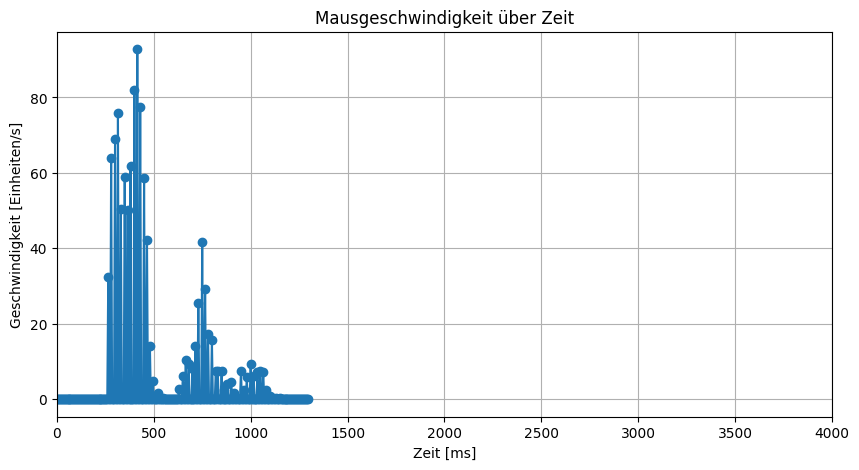

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Beispiel: eine einzelne speed-Liste aus einem Trial
speed = processed_dataframes_clean[0]['speed'].iloc[0]  # oder wo immer dein Trial ist

# Zeitachse in Millisekunden
time_ms = np.arange(len(speed)) * 5  # 5ms pro Messwert

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_ms, speed, marker='o')
plt.xlim(0, 4000)
plt.xlabel('Zeit [ms]')
plt.ylabel('Geschwindigkeit [Einheiten/s]')
plt.title('Mausgeschwindigkeit über Zeit')
plt.grid(True)
plt.show()


### Nach Condition aufsplitten

In [126]:
df_lld = []
df_rld = []

for df in processed_dataframes_clean:
    version = df.iloc[0]['version'] 
    if version == 'lld':
        df_lld.append(df)
    elif version == 'rld':
        df_rld.append(df)


In [127]:
df_lld[0].head()

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,speed_interp
0,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.0, 0, 0, 0.0, 0, 0, 3.2557641192199385, 0, ...","[0.0, 0.0, 1.8745308565205723, 0.3636363636363..."
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[0.0, 0, 0, 4.6, 0, 0, 1.6, 0, 0, 0, 0.4000000...","[0.0, 0.0, 0.0, 2.0363636363636393, 0.79191919..."
3,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 2.1999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.222222222222217, 0..."
4,1,6,"[14:14:33.072, 14:14:33.089, 14:14:33.106, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0219999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02199999...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88888888..."


In [128]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

In [129]:
for i, df in enumerate(df_lld):
    target_pos_series = df.apply(get_target_pos, axis=1)
    df_lld[i] = df.copy() 
    df_lld[i]['targetPos'] = target_pos_series

In [130]:
for i, df in enumerate(df_rld):
    target_pos_series = df.apply(get_target_pos, axis=1)
    df_rld[i] = df.copy()  # sicherstellen, dass es ein DataFrame ist
    df_rld[i]['targetPos'] = target_pos_series

In [131]:
df_lld[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,speed_interp,targetPos
0,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.0, 0, 0, 0.0, 0, 0, 3.2557641192199385, 0, ...","[0.0, 0.0, 1.8745308565205723, 0.3636363636363...",l
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[0.0, 0, 0, 4.6, 0, 0, 1.6, 0, 0, 0, 0.4000000...","[0.0, 0.0, 0.0, 2.0363636363636393, 0.79191919...",l
3,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 2.1999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.222222222222217, 0...",r
4,1,6,"[14:14:33.072, 14:14:33.089, 14:14:33.106, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0219999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02199999...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88888888...",r
...,...,...,...,...,...,...,...,...,...,...,...
434,8,56,"[14:43:43.159, 14:43:43.175, 14:43:43.191, 14:...","[0.0, 0.01100000000000001, 0.03800000000000000...","[0.0, 0.0, 0.0, 0.0, -0.01100000000000001, -0....",lld,1085,"[0.0, 0.01100000000000001, 0.02699999999999999...","[0.0, 0, 0, 2.200000000000002, 0, 0, 5.3999999...","[0.0, 1.2545454545454566, 8.137373737373721, 2...",l
435,8,57,"[14:43:48.209, 14:43:48.225, 14:43:48.245, 14:...","[0.0, -0.10999999999999999, -0.192, -0.2870000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.10999999999999999, 0.08200000000000002...","[0.0, 0, 0, 21.999999999999996, 0, 0, 0, 16.40...","[0.0, 0.0, 2.222222222222218, 0.0, 3.313131313...",l
436,8,58,"[14:43:51.614, 14:43:51.624, 14:43:51.641, 14:...","[0.0, -0.0030000000000000027, -0.0270000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000000...",lld,1085,"[0.0, 0.0030000000000000027, 0.024000000000000...","[0.0, 0, 0.6000000000000005, 0, 0, 4.800000000...","[0.0, 0.0, 0.0, 3.939393939393937, 1.860657606...",r
437,8,59,"[14:43:55.442, 14:43:55.460, 14:43:55.475, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01100000000000001...","[0.0, 0.000999999999999994, 0.0009999999999999...",lld,1085,"[0.0, 0.000999999999999994, 0.0, 0.0, 0.0, 0.0...","[0.0, 0, 0, 0.1999999999999988, 0, 0, 0.0, 0, ...","[0.0, 0.19191919191919082, 0.0, 0.0, 0.0, 0.0,...",l


### Jetzt werden die zwei conditions noch nach targetPos aufgesplittet

In [132]:
df_lld_left_target = []
df_lld_right_target = []

for df in df_lld:
    df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
    df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
    df_lld_left_target.append(df_left)
    df_lld_right_target.append(df_right)


In [133]:
df_rld_left_target = []
df_rld_right_target = []

for df in df_rld:
    df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
    df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
    df_rld_left_target.append(df_left)
    df_rld_right_target.append(df_right)


In [134]:
len(df_rld_left_target)

25

In [135]:
df_rld_left_target[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,speed_interp,targetPos
0,1,2,"[22:14:53.083, 22:14:53.099, 22:14:53.114, 22:...","[0.0, 0.007000000000000006, 0.0100000000000000...","[0.0, -0.0020000000000000018, -0.0020000000000...",rld,1611,"[0.0, 0.007280109889280525, 0.0030000000000000...","[0.0, 0, 0, 1.456021977856105, 0, 0, 0.6000000...","[0.0, 0.0, 0.23531668328987498, 0.454545454545...",l
1,1,5,"[22:15:01.539, 22:15:01.555, 22:15:01.572, 22:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,1611,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",l
2,1,6,"[22:15:03.605, 22:15:03.622, 22:15:03.647, 22:...","[0.0, -0.07600000000000051, -0.102000000000000...","[0.0, 0.017000000000000015, 0.0620000000000000...",rld,1611,"[0.0, 0.07787810988975065, 0.05197114584074503...","[0.0, 0, 0, 15.57562197795013, 0, 0, 0, 0, 10....","[0.0, 13.530338283875867, 0.0, 1.2704163724591...",l
3,1,7,"[22:15:06.538, 22:15:06.565, 22:15:06.571, 22:...","[0.0, 0.016999999999999904, 0.0219999999999997...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,1611,"[0.0, 0.016999999999999904, 0.0049999999999998...","[0.0, 0, 0, 0, 0, 3.399999999999981, 0.9999999...","[0.0, 0.0, 2.404040404040392, 0.0, 0.165656565...",l
4,1,9,"[22:15:12.488, 22:15:12.515, 22:15:12.521, 22:...","[0.0, 0.0, 0.0, 0.034, 0.07899999999999999, 0....","[0.0, 0.011999999999999997, 0.015, 0.027999999...",rld,1611,"[0.0, 0.011999999999999997, 0.0030000000000000...","[0.0, 0, 0, 0, 0, 2.3999999999999995, 0.600000...","[0.0, 0.0, 0.0, 1.7454545454545463, 0.41818181...",l
...,...,...,...,...,...,...,...,...,...,...,...
226,8,50,"[22:36:42.909, 22:36:42.926, 22:36:42.942, 22:...","[0.0, 0.16799999999999998, 0.382, 0.6799999999...","[0.0, -0.061000000000000006, -0.127, -0.183, -...",rld,1611,"[0.0, 0.1787316424139833, 0.22394642216387384,...","[0.0, 0, 0, 35.746328482796656, 0, 0, 44.78928...","[0.0, 0.0, 28.163773956142826, 0.0, 25.7877698...",l
227,8,52,"[22:36:47.275, 22:36:47.303, 22:36:47.308, 22:...","[0.0, -0.05500000000000005, -0.084999999999999...","[0.0, -0.0010000000000000009, -0.0010000000000...",rld,1611,"[0.0, 0.05500909015790032, 0.02999999999999991...","[0.0, 0, 0, 0, 0, 11.001818031580065, 5.999999...","[0.0, 0.0, 0.0, 0.0, 6.223250603722062, 7.4651...",l
228,8,54,"[22:36:51.475, 22:36:51.492, 22:36:51.508, 22:...","[0.0, 0.0, 0.0, 0.03399999999999999, 0.0559999...","[0.0, 0.0, 0.0, 0.0, 0.010999999999999996, 0.0...",rld,1611,"[0.0, 0.0, 0.0, 0.03399999999999999, 0.0245967...","[0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 6.7999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.563...",l
229,8,55,"[22:36:53.236, 22:36:53.251, 22:36:53.267, 22:...","[0.0, 0.01200000000000001, 0.02700000000000002...","[0.0, 0.014999999999999958, 0.0199999999999999...",rld,1611,"[0.0, 0.01920937271229852, 0.01581138830084191...","[0.0, 0, 0, 3.841874542459704, 0, 0, 3.1622776...","[0.0, 0.0, 2.871704203454727, 0.0, 1.565167730...",l


### Durchschnittskurve für jeden Participant

In [136]:
import numpy as np

avg_speed_per_participant_lld_left = []  # Liste von np.arrays mit je 100 Werten

for df in df_lld_left_target:
    # Stacke alle speed_interp arrays zu einer (n_trials x 100) Matrix
    speed_matrix = np.stack(df['speed_interp'].values)
    
    # Mittelwert über alle Trials (Zeilen) → ergibt ein 100-Längen-Array
    mean_speed = np.mean(speed_matrix, axis=0)
    
    avg_speed_per_participant_lld_left.append(mean_speed)


In [137]:
avg_speed_per_participant_lld_left

[array([ 0.        ,  2.29974581,  3.3463709 ,  2.76222   ,  4.07452494,
         2.94324278,  2.94441493,  3.2304114 ,  3.01362373,  2.75431712,
         3.1721427 ,  3.14665024,  3.02472331,  2.50721274,  1.93399406,
         2.36865357,  3.74727756,  4.35062465,  3.37175322,  5.98822708,
         6.65617009,  8.61880333,  7.8417331 ,  8.52209449,  8.87982179,
         9.08400009,  7.98985224,  8.34401695, 11.6528869 ,  9.34674802,
         9.53480734, 11.45497869,  6.96211354,  8.53512578, 10.35820086,
         7.67533313,  8.29468389,  6.09003947,  5.44410736,  6.14627983,
         5.85092039,  6.49844915,  5.55242023,  5.28047982,  6.35047357,
         4.02079948,  3.74325304,  4.28862185,  4.34442821,  3.36626523,
         3.64297734,  3.08230401,  3.00455011,  3.51972753,  2.79293217,
         2.99086362,  2.61006807,  2.50278603,  2.66357725,  2.28136768,
         2.18928581,  1.81527354,  1.67880261,  1.68675329,  2.20881671,
         1.87860674,  2.25104648,  1.65146774,  1.4

In [138]:
import numpy as np

avg_speed_per_participant_lld_right = []  # Liste von np.arrays mit je 100 Werten

for df in df_lld_right_target:
    # Stacke alle speed_interp arrays zu einer (n_trials x 100) Matrix
    speed_matrix = np.stack(df['speed_interp'].values)
    
    # Mittelwert über alle Trials (Zeilen) → ergibt ein 100-Längen-Array
    mean_speed = np.mean(speed_matrix, axis=0)
    
    avg_speed_per_participant_lld_right.append(mean_speed)


In [139]:
import numpy as np

avg_speed_per_participant_rld_left = []  # Liste von np.arrays mit je 100 Werten

for df in df_rld_left_target:
    # Stacke alle speed_interp arrays zu einer (n_trials x 100) Matrix
    speed_matrix = np.stack(df['speed_interp'].values)
    
    # Mittelwert über alle Trials (Zeilen) → ergibt ein 100-Längen-Array
    mean_speed = np.mean(speed_matrix, axis=0)
    
    avg_speed_per_participant_rld_left.append(mean_speed)


In [140]:
import numpy as np

avg_speed_per_participant_rld_right = []  # Liste von np.arrays mit je 100 Werten

for df in df_rld_right_target:
    # Stacke alle speed_interp arrays zu einer (n_trials x 100) Matrix
    speed_matrix = np.stack(df['speed_interp'].values)
    
    # Mittelwert über alle Trials (Zeilen) → ergibt ein 100-Längen-Array
    mean_speed = np.mean(speed_matrix, axis=0)
    
    avg_speed_per_participant_rld_right.append(mean_speed)


In [141]:
avg_speed_per_participant_lld_left[0]

array([ 0.        ,  2.29974581,  3.3463709 ,  2.76222   ,  4.07452494,
        2.94324278,  2.94441493,  3.2304114 ,  3.01362373,  2.75431712,
        3.1721427 ,  3.14665024,  3.02472331,  2.50721274,  1.93399406,
        2.36865357,  3.74727756,  4.35062465,  3.37175322,  5.98822708,
        6.65617009,  8.61880333,  7.8417331 ,  8.52209449,  8.87982179,
        9.08400009,  7.98985224,  8.34401695, 11.6528869 ,  9.34674802,
        9.53480734, 11.45497869,  6.96211354,  8.53512578, 10.35820086,
        7.67533313,  8.29468389,  6.09003947,  5.44410736,  6.14627983,
        5.85092039,  6.49844915,  5.55242023,  5.28047982,  6.35047357,
        4.02079948,  3.74325304,  4.28862185,  4.34442821,  3.36626523,
        3.64297734,  3.08230401,  3.00455011,  3.51972753,  2.79293217,
        2.99086362,  2.61006807,  2.50278603,  2.66357725,  2.28136768,
        2.18928581,  1.81527354,  1.67880261,  1.68675329,  2.20881671,
        1.87860674,  2.25104648,  1.65146774,  1.47446809,  2.01

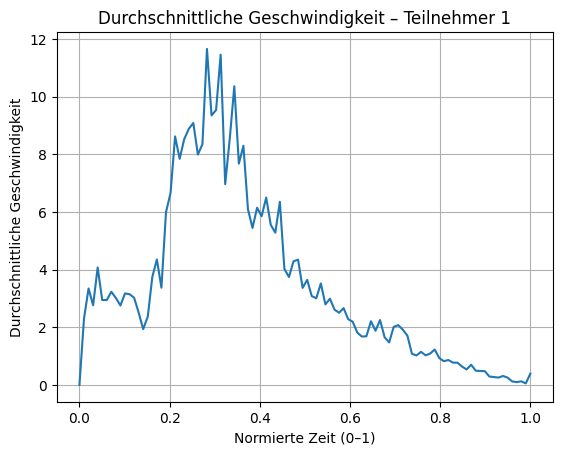

In [142]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 1, 100), avg_speed_per_participant_lld_left[0])
plt.xlabel("Normierte Zeit (0–1)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Teilnehmer 1")
plt.grid(True)
plt.show()


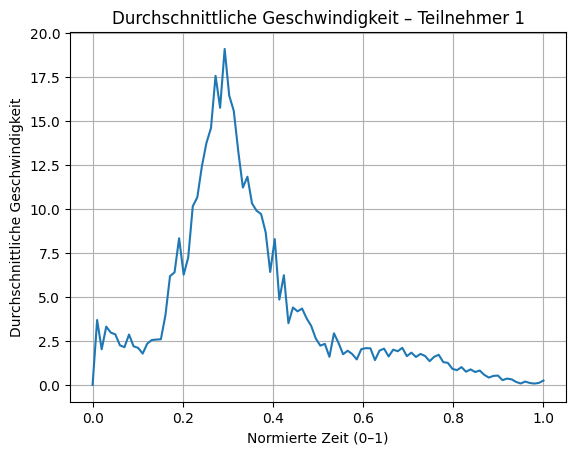

In [143]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 1, 100), avg_speed_per_participant_lld_right[0])
plt.xlabel("Normierte Zeit (0–1)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Teilnehmer 1")
plt.grid(True)
plt.show()


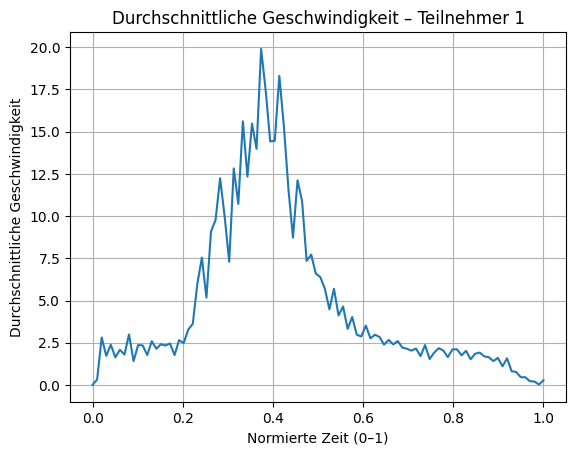

In [144]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 1, 100), avg_speed_per_participant_rld_left[0])
plt.xlabel("Normierte Zeit (0–1)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Teilnehmer 1")
plt.grid(True)
plt.show()


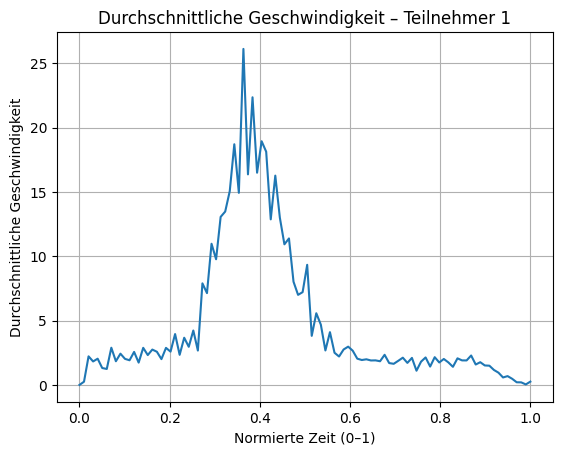

In [145]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 1, 100), avg_speed_per_participant_rld_right[0])
plt.xlabel("Normierte Zeit (0–1)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Teilnehmer 1")
plt.grid(True)
plt.show()


In [146]:
speed_matrix_lld_left = np.stack(avg_speed_per_participant_lld_left)
speed_matrix_lld_right = np.stack(avg_speed_per_participant_lld_right)
speed_matrix_rld_left = np.stack(avg_speed_per_participant_rld_left)
speed_matrix_rld_right = np.stack(avg_speed_per_participant_rld_right)

# Durchschnitt über alle 25 Teilnehmer pro Timestep
mean_speed_lld_left = np.mean(speed_matrix_lld_left, axis=0)
mean_speed_lld_right = np.mean(speed_matrix_lld_right, axis=0)
mean_speed_rld_left = np.mean(speed_matrix_rld_left, axis=0)
mean_speed_rld_right = np.mean(speed_matrix_rld_right, axis=0)


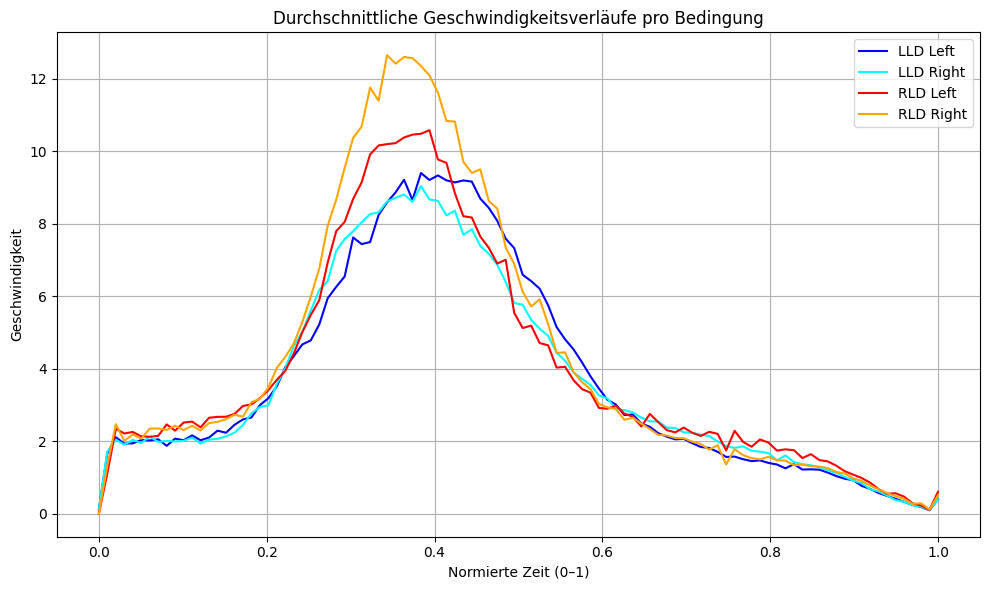

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Normierte Zeitachse mit 100 Timesteps
timesteps = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 6))

plt.plot(timesteps, mean_speed_lld_left, label="LLD Left", color="blue")
plt.plot(timesteps, mean_speed_lld_right, label="LLD Right", color="cyan")
plt.plot(timesteps, mean_speed_rld_left, label="RLD Left", color="red")
plt.plot(timesteps, mean_speed_rld_right, label="RLD Right", color="orange")

plt.title("Durchschnittliche Geschwindigkeitsverläufe pro Bedingung")
plt.xlabel("Normierte Zeit (0–1)")
plt.ylabel("Geschwindigkeit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [148]:
# Zeitachse von 0 bis 4000 ms in 5-ms-Schritten
target_time_ms = np.arange(0, 4000 + 1, 5)  # ergibt 801 Punkte: 0, 5, 10, ..., 4000

avg_speed_per_participant_lld_left = []

for df in df_lld_left_target:
    aligned_speeds = []

    for speed in df['speed']:
        time = np.arange(len(speed)) * 5  # echte Zeitpunkte in ms

        # Interpoliere auf die feste Zielzeitachse, außerhalb: NaN
        if len(speed) > 1:
            interp_speed = np.interp(target_time_ms, time, speed, left=np.nan, right=np.nan)
            aligned_speeds.append(interp_speed)

    # Erzeuge (n_trials x 801) Matrix
    speed_matrix = np.vstack(aligned_speeds)

    # Mittelwert über alle Trials, ignoriere NaNs
    mean_speed = np.nanmean(speed_matrix, axis=0)

    avg_speed_per_participant_lld_left.append(mean_speed)


C:\Users\m_uel\AppData\Local\Temp\ipykernel_26068\3432765161.py:21: RuntimeWarning: Mean of empty slice
  mean_speed = np.nanmean(speed_matrix, axis=0)


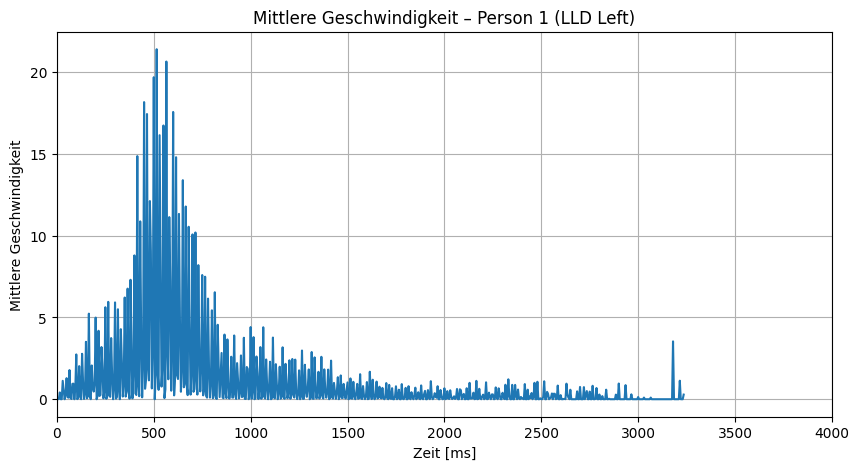

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(target_time_ms, avg_speed_per_participant_lld_left[8])
plt.xlabel("Zeit [ms]")
plt.ylabel("Mittlere Geschwindigkeit")
plt.title("Mittlere Geschwindigkeit – Person 1 (LLD Left)")
plt.xlim(0, 4000)
plt.grid(True)
plt.show()


In [150]:
# Zeitachse von 0 bis 4000 ms in 5-ms-Schritten
target_time_ms = np.arange(0, 4000 + 1, 5)  # ergibt 801 Punkte: 0, 5, 10, ..., 4000

avg_speed_per_participant_lld_right = []

for df in df_lld_right_target:
    aligned_speeds = []

    for speed in df['speed']:
        time = np.arange(len(speed)) * 5  # echte Zeitpunkte in ms

        # Interpoliere auf die feste Zielzeitachse, außerhalb: NaN
        if len(speed) > 1:
            interp_speed = np.interp(target_time_ms, time, speed, left=np.nan, right=np.nan)
            aligned_speeds.append(interp_speed)

    # Erzeuge (n_trials x 801) Matrix
    speed_matrix = np.vstack(aligned_speeds)

    # Mittelwert über alle Trials, ignoriere NaNs
    mean_speed = np.nanmean(speed_matrix, axis=0)

    avg_speed_per_participant_lld_right.append(mean_speed)

len(avg_speed_per_participant_lld_right[0])


C:\Users\m_uel\AppData\Local\Temp\ipykernel_26068\3548661910.py:21: RuntimeWarning: Mean of empty slice
  mean_speed = np.nanmean(speed_matrix, axis=0)


801

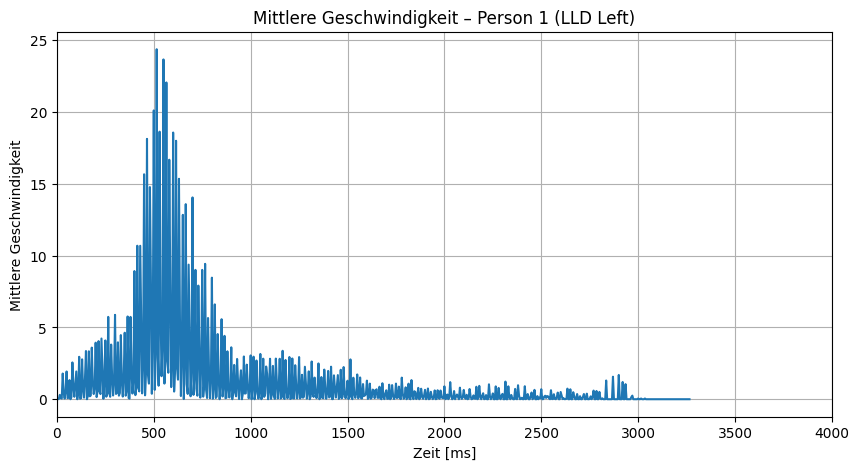

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(target_time_ms, avg_speed_per_participant_lld_right[8])
plt.xlabel("Zeit [ms]")
plt.ylabel("Mittlere Geschwindigkeit")
plt.title("Mittlere Geschwindigkeit – Person 1 (LLD Left)")
plt.xlim(0, 4000)
plt.grid(True)
plt.show()


In [152]:
# Umwandeln in (n_personen x 801) Matrix
group_matrix = np.vstack(avg_speed_per_participant_lld_left)

# Mittelwert über Personen hinweg (Achse 0)
mean_speed_lld_left = np.nanmean(group_matrix, axis=0)


C:\Users\m_uel\AppData\Local\Temp\ipykernel_26068\2490571187.py:5: RuntimeWarning: Mean of empty slice
  mean_speed_lld_left = np.nanmean(group_matrix, axis=0)


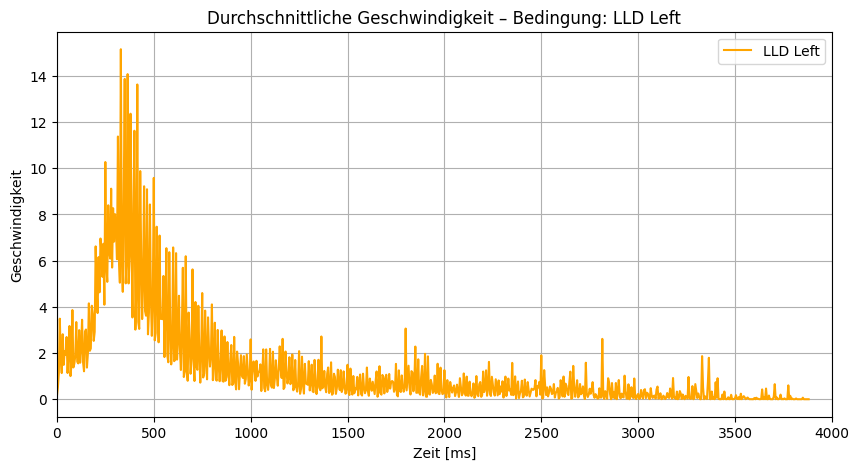

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(target_time_ms, mean_speed_lld_left, color='orange', label='LLD Left')
plt.xlabel("Zeit [ms]")
plt.ylabel("Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Bedingung: LLD Left")
plt.xlim(0, 4000)
plt.grid(True)
plt.legend()
plt.show()


In [154]:
# Umwandeln in (n_personen x 801) Matrix
group_matrix = np.vstack(avg_speed_per_participant_lld_right)

# Mittelwert über Personen hinweg (Achse 0)
mean_speed_lld_right = np.nanmean(group_matrix, axis=0)


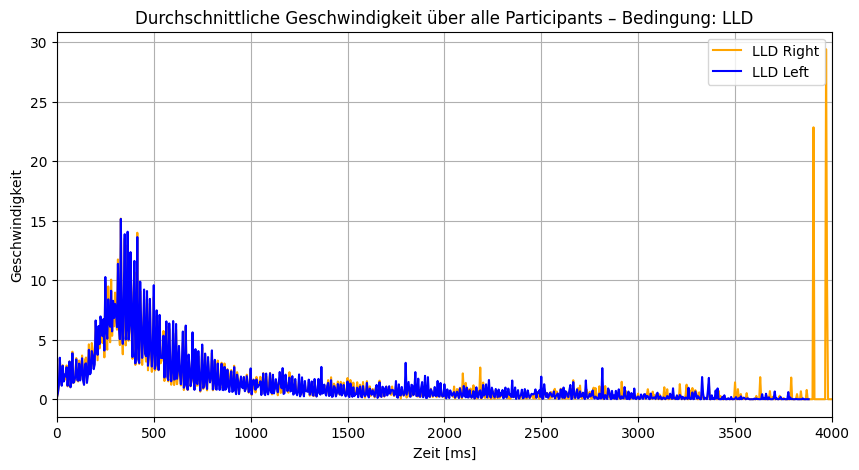

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(target_time_ms, mean_speed_lld_right, color='orange', label='LLD Right')
plt.plot(target_time_ms, mean_speed_lld_left, color='blue', label='LLD Left')
plt.xlabel("Zeit [ms]")
plt.ylabel("Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit über alle Participants – Bedingung: LLD")
plt.xlim(0, 4000)
plt.grid(True)
plt.legend()
plt.show()
